**Part two of my fun project to train a model over tweets of Donald Trump and try to create new tweets. As a start, I tried out simple LSTM model and done some experimentations with that by applying/removing embedding layers, increasing hidden units, adding more layers but model had a tendency to repeat text after some time. So as a conclusion for this small project In this notebook I try to use Transformers to generate new tweets.**

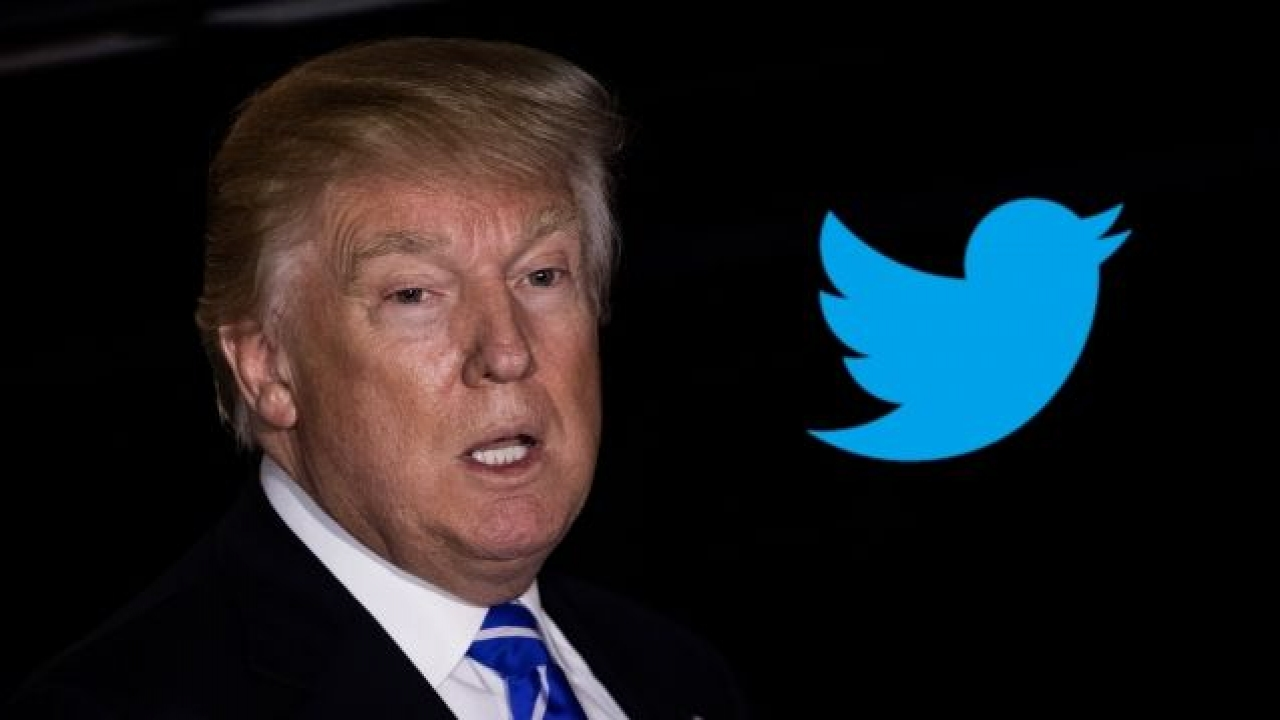

Note: As at the time of of this notebook, I am only learning transformers so please correct me in the comments if you have some better suggestion.

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

**I loaded the dataset and then only used the tweet column for text generation**

In [ ]:
data = pd.read_csv('../input/all-trumps-twitter-insults-20152021/trump_insult_tweets_2014_to_2021.csv')
data.head()

In [ ]:
tweets = data['tweet'].copy()
del data

**Here I added three new tokens in the pre-trained GPT2 tokenizer: \
<|sos|> : start of sentence \
<|eos|> : end of sentence \
<|pad|> : padding token**

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

In [ ]:
max_tweet = max([len(tokenizer.encode(tweet)) for tweet in tweets])

print(f'The longest tweet is {max_tweet} tokens long.')

**Next we create a custom dataloader for our tweets using torch Dataset. \
Each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask**

In [ ]:
batch_size = 32

import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
    def __init__(self,tweets,tokenizer,gpt2_type="gpt2",max_length=max_tweet):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for tweet in tweets:
            encoding_dict = tokenizer('<|sos|>'+ tweet +'<|eos|>',truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
            
            self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention_masks[idx]

In [ ]:
from torch.utils.data import random_split
dataset = TweetDataset(tweets,tokenizer,max_length=max_tweet)

**We use 90% dataset for training and 10% for validation.**

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset)-train_size

train,val = random_split(dataset,[train_size,val_size])
print(f'No of train samples = {train_size} and Number of validation samples = {val_size}')

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(train,sampler = RandomSampler(train),
                             batch_size = batch_size)

val_dataloader = DataLoader(val,sampler = SequentialSampler(val),
                           batch_size = batch_size)

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 6
warmup_steps = 1e2
sample_every = 100

**Algorithm for AdamW optimizer** \
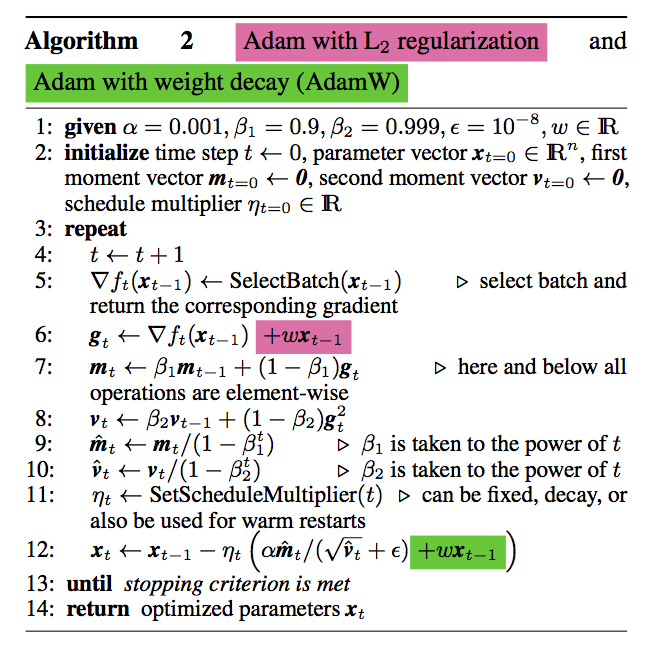

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

**Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model.**

**We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.**

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

In [ ]:
import os
out_dir = '/TrumpTweet'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')

**Let's see how well our model performs**

In [ ]:
model.eval()

prompt = "<|sos|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [ ]:
#Load Saved Model

model = GPT2LMHeadModel.from_pretrained('./')
tokenizer = GPT2Tokenizer.from_pretrained('./')
model.to(device)


**Let's use a tweet from Trump's account from 2012.**

In [ ]:
tweet_2012 = 'it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have'

In [ ]:
model.eval()

prompt = tweet_2012

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

**We can clearly see how well Transformers perform when compared to LSTM model which produced something like this:**

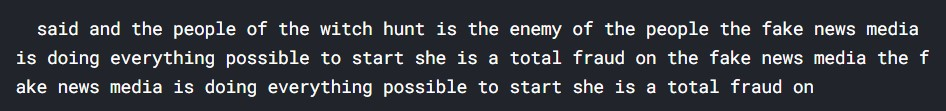

**Next I will try this model on some other famous personalities on twitter.**

You can have a look at the [LSTM Notebook](https://www.kaggle.com/ajay19/trump-tweet-generation).